# Training and Validation

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from PIL import Image
from datetime import datetime
import os, json, cv2, random, pathlib, shutil
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# import helper functions
import helper as h

## Register Dataset

In [7]:
# Input Arguments
dataset_path = "../../google-drive/"   # root directory of project data
dataset_name = "stomata100" # name of the dataset 
output_folder = "./output" # folder where to output training and validation results.
class_name = "stomata"  # name for the class in instance segmentation
seed_num = 28825252
print_example = True  # switch if to print out exmaple images in the training set.

# Initialise Variables
label_filenames = {}
for d in ["train", "val"]:
    label_filenames[d] = os.path.join(dataset_path, dataset_name, "labels", f"labels_{d}.json")

#####################
# REGISTER DATASETS #
#####################

# register training set and validation set using COCO
# Note these they can only be registered once.
# There is an interesting bug when COCO read JSON files, it should get a list[dict]
# however it asserts list[dict] with dict and return an error. Not sure how to solve it.

# register_coco_instances("train_dataset", {}, train_label_filename, train_label_filename)
# register_coco_instances("val_dataset", {}, val_label_filename, val_img_dir)

for d in ["train", "val"]:
    catelog_name = f"{dataset_name}_{d}"
    print(catelog_name)
    if catelog_name in DatasetCatalog:
        DatasetCatalog.remove(catelog_name)
    if catelog_name in MetadataCatalog:
        MetadataCatalog.remove(catelog_name)
    
    print("load ", label_filenames[d], " to DatasetCatalog...")
    DatasetCatalog.register(catelog_name, lambda d=d: h.get_detectron2_dicts(json_filename = label_filenames[d]))
    MetadataCatalog.get(catelog_name).set(thing_classes=[class_name])

stomata_metadata = MetadataCatalog.get(f"{dataset_name}_train")

stomata100_train
load  ../../google-drive/stomata100/labels/labels_train.json  to DatasetCatalog...
stomata100_val
load  ../../google-drive/stomata100/labels/labels_val.json  to DatasetCatalog...


## Dataset visualisation

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:

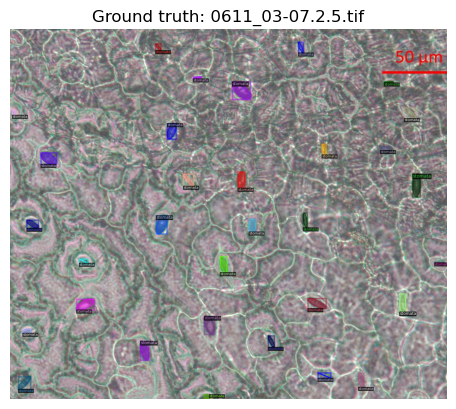

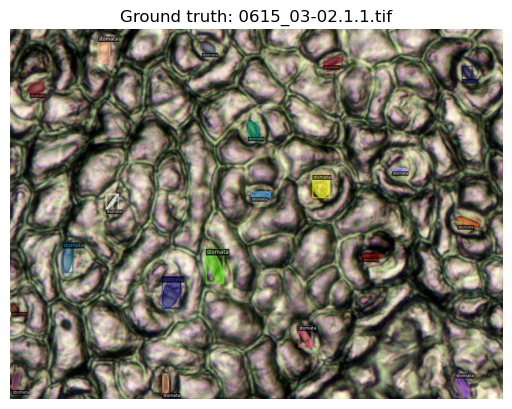

In [10]:
my_dataset_train_metadata = MetadataCatalog.get(dataset_name + "_train")
dataset_dicts = DatasetCatalog.get(dataset_name + "_train")

# Draw annotated examples from training data.
if print_example:
    num_example = 2
    for d in random.sample(dataset_dicts, num_example):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1)
        out = visualizer.draw_dataset_dict(d)
        
        plt.figure()
        plt.imshow(out.get_image())
        plt.axis('off')
        plt.title("Ground truth: {}".format(os.path.basename(d["file_name"])))

## Training

### Set up Detection Configurations

Test training configurations and hyperparameters. Important hyper-parameters are:
- cfg.SOLVER.IMS_PER_BATCH: batch size
- cfg.SOLVER.BASE_LR: learning rate
- cfg.SOLVER.STEPS: learning rate decay
- 

See [official documentation](https://detectron2.readthedocs.io/en/latest/modules/config.html) for further information, and [here for transfer learning](https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

> **TODO**   
> Here we plan to use `train_net.py` to enable multi-GPU training.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (f"{dataset_name}_train",)
cfg.DATASETS.TEST = (f"{dataset_name}_val", )
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 32000 # you may need to train longer for a practical dataset 300, 1000?
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.REFERENCE_WORLD_SIZE = 1    # REFERENCE_WORLD_SIZE * MAX_ITER = TOTAL_ITERATION

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (stomata).
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE = "cuda:2"    # train with CUDA

# Create
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
result_dir = os.path.join(output_folder,f"{dataset_name}_output_ep{int(cfg.SOLVER.MAX_ITER*cfg.SOLVER.REFERENCE_WORLD_SIZE)}_{dt_string}")
os.makedirs(result_dir, exist_ok=True)
cfg.OUTPUT_DIR= os.path.join(result_dir, "train_output")
 
#print(cfg)

### STEP 2: Start Training

In [ ]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

trainer.train()
train_history_output = os.path.join(cfg.OUTPUT_DIR,'train_history.txt')
    
# THIS IS FOR MLUTIPLE GPUS. DOESN'T WORK AT THE MOMENT
#!python ../tools/train_net.py --num-gpus 2  --dist-url "tcp://100.100.8.127:8989"

# Inference & evaluation using the trained model

Now, let's run inference with the trained model on the stomata validation dataset. First, let's create a predictor using the model we just trained.
Inference should use the config with parameters that are used in training
cfg now already contains everything we've set previously. We changed it a little bit for inference:

In [ ]:
# load trained data
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.INPUT.MIN_SIZE_TEST = 0 # disable resize in testing
predictor = DefaultPredictor(cfg)

In [ ]:

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

output_dir = os.path.join(result_dir, "val_output")
os.makedirs(output_dir, exist_ok=True)

evaluator = COCOEvaluator(f"{dataset_name}_val", output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, f"{dataset_name}_val")
with open(os.path.join(output_dir, "val_output.txt"), "w") as f:    
    print("random_seed: ", seed_num, file = f)
    print("batch_size: ", cfg.SOLVER.IMS_PER_BATCH, file = f)
    print("num_iteration: ", cfg.SOLVER.MAX_ITER, file = f)
    print("processes:", cfg.SOLVER.REFERENCE_WORLD_SIZE, file = f)
    print(inference_on_dataset(predictor.model, val_loader, evaluator),file=f)
# another equivalent way to evaluate the model is to use `trainer.test`